In [26]:
import torch
from torchvision import datasets
from torch import nn
import matplotlib.pyplot as plt

%matplotlib inline

### Download CIFAR-10

In [3]:
data_path = "../data/cifar-10/"

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Using downloaded and verified file: ../data/cifar-10/cifar-10-python.tar.gz
Extracting ../data/cifar-10/cifar-10-python.tar.gz to ../data/cifar-10/
Files already downloaded and verified


### Check the dataset 

In [4]:
len(cifar10)

50000

In [5]:
img, label = cifar10[9]
img, label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x12F890160>, 3)

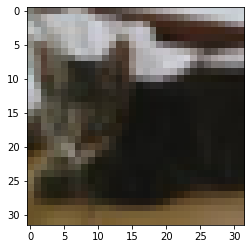

In [7]:
plt.imshow(img)
plt.show()

### Dataset transforms

In [8]:
from torchvision import transforms

dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

#### PIL to Tensor

In [9]:
to_tensor = transforms.ToTensor()

img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [11]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.ToTensor())

In [12]:
img_t, _ = tensor_cifar10[9]

img_t.shape, type(img_t)

(torch.Size([3, 32, 32]), torch.Tensor)

In [14]:
# ToTensor turn data into 32-bit floating point, 
# scale the values down from 0.0 to 1.0
img_t.min(), img_t.max()

(tensor(0.0431), tensor(0.8549))

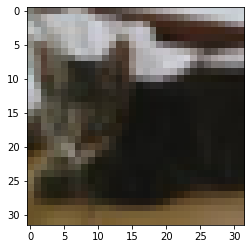

In [16]:
# matplotlib expects dimesion H x W x C

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### Normalizing data

In [17]:
# Stack all images

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [18]:
# Compute mean and std overall

mean = imgs.view(3, -1).mean(1) # shape: 3x32x32 -> 3x1024, take mean over 1024 elements of each channel
std = imgs.view(3, -1).std(1)

mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [19]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, 
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=mean, std=std)
                                       ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


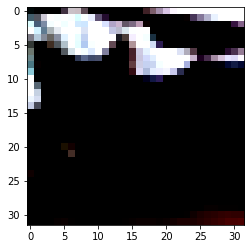

In [20]:
img_t, _ = transformed_cifar10[9]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Distinguishing birds from airplanes

### Building the dataset

In [34]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']

# In PyTorch, a dataset must have __len__ and __getitem__ method
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]

### Build the model

In [40]:
n_out = 2
n_in = 32*32*3

model = nn.Sequential(
    nn.Linear(in_features=n_in, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, n_out),
    nn.LogSoftmax(dim=1)
)

loss_fn = nn.NLLLoss()
learning_rate = 1e-2
optimzer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [41]:
from torchsummary import summary

summary(model, (1, 3*32*32), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [1, 1, 512]       1,573,376
              ReLU-2                [1, 1, 512]               0
           Dropout-3                [1, 1, 512]               0
            Linear-4                [1, 1, 256]         131,328
              ReLU-5                [1, 1, 256]               0
           Dropout-6                [1, 1, 256]               0
            Linear-7                [1, 1, 128]          32,896
              ReLU-8                [1, 1, 128]               0
            Linear-9                  [1, 1, 2]             258
       LogSoftmax-10                  [1, 1, 2]               0
Total params: 1,737,858
Trainable params: 1,737,858
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 6.63
Estimat

### Training the model with DataLoader

In [42]:
n_epochs = 10
batch_size = 64
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]

        out = model(imgs.view(batch_size, -1)) # 64x3x32x32 -> 64x...
        loss = loss_fn(out, labels)
        
        optimzer.zero_grad()
        loss.backward()
        optimzer.step()

    if epoch % 1 == 0:
        print(f"Epoch {epoch} loss {loss:>3f}")


Epoch 0 loss 0.610564
Epoch 1 loss 0.473274
Epoch 2 loss 0.501388
Epoch 3 loss 0.541051
Epoch 4 loss 0.299133
Epoch 5 loss 0.599735
Epoch 6 loss 0.469886
Epoch 7 loss 0.654873
Epoch 8 loss 0.272867
Epoch 9 loss 0.200476


### Evaluate model

In [47]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        
        out = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(out, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print(f"Accuracy {correct/total}")

Accuracy 0.8624
